In [2]:
# Import modules
import numpy as np
from qiskit import(
    QuantumCircuit,
    execute,
    Aer,
    QuantumRegister,
    ClassicalRegister
    )

from qiskit.visualization import plot_histogram

In [45]:
# Define our registers and circuit
qb = QuantumRegister(5, 'code_qubit')     # The 5 qubits to encode the state in
an = QuantumRegister(4, 'ancilla_qubit')  # The two ancilla qubits (one of them is unused)
cr = ClassicalRegister(4, 'syndrome_bit') # Classical register for registering the syndromes
readout = ClassicalRegister(5, 'readout')   # Readout of the final state at the end for statistics

In [49]:
# Encode the input into logical 0 and 1
# This encoding brings |00000> to the correct state but
# with incorrect amplitudes
def encode_input( circuit, qbReg ):
    circuit.h( qbReg[0] )
    circuit.h( qbReg[1] )
    circuit.h( qbReg[2] )
    circuit.h( qbReg[3] )
    
    circuit.cx( qbReg[0], qbReg[1] )
    circuit.cx( qbReg[0], qbReg[2] )
    circuit.cx( qbReg[0], qbReg[3] )
    circuit.cx( qbReg[0], qbReg[4] )
    
    circuit.cx( qbReg[1], qbReg[2] )
    circuit.cx( qbReg[1], qbReg[3] )
    circuit.cx( qbReg[1], qbReg[4] )
    
    circuit.cx( qbReg[2], qbReg[3] )
    circuit.cx( qbReg[2], qbReg[4] )
    
    circuit.cx( qbReg[3], qbReg[4] )

    return

# Define our stabilizers
def measure_stabilizer( circuit, qbReg, anReg, clReg, i ):
    '''Function for adding stabilizer measurements to a circuit.
    Note that a measurement of X is done by using Hadamard before
    and after. Input i specifies the stabilizer to measure:
        i=0: XZZXI
        i=1: IXZZX
        i=2: XIXZZ
        i=3: ZXIXZ
    Other inputs are the circuit as well as the required registers'''
    
    if not isinstance(i, int):
        raise error('i must be an integer')
    
    # Generate indexes
    index = np.mod( i + np.array([0, 1, 2, 3]), 5 ) 
    
    # Measure stabilizers
    circuit.h( qbReg[ index[0] ] )
    circuit.cx( qbReg[ index[0] ], anReg[i] )
    circuit.h( qbReg[ index[0] ] ) 
        
    circuit.cx( qbReg[ index[1] ], anReg[i] )
        
    circuit.cx( qbReg[ index[2] ], anReg[i] )
        
    circuit.h( qbReg[ index[3] ] )
    circuit.cx( qbReg[ index[3] ], anReg[i] )
    circuit.h( qbReg[ index[3] ])
        
#    circuit.measure( anReg[i], clReg[i])
    
    return
    


{'00000 0000': 60, '10001 0000': 67, '10010 0000': 62, '10100 0000': 60, '10111 0000': 64, '11000 0000': 53, '11011 0000': 75, '11101 0000': 84, '11110 0000': 70, '00011 0000': 63, '00101 0000': 72, '00110 0000': 56, '01001 0000': 61, '01010 0000': 62, '01100 0000': 60, '01111 0000': 55}


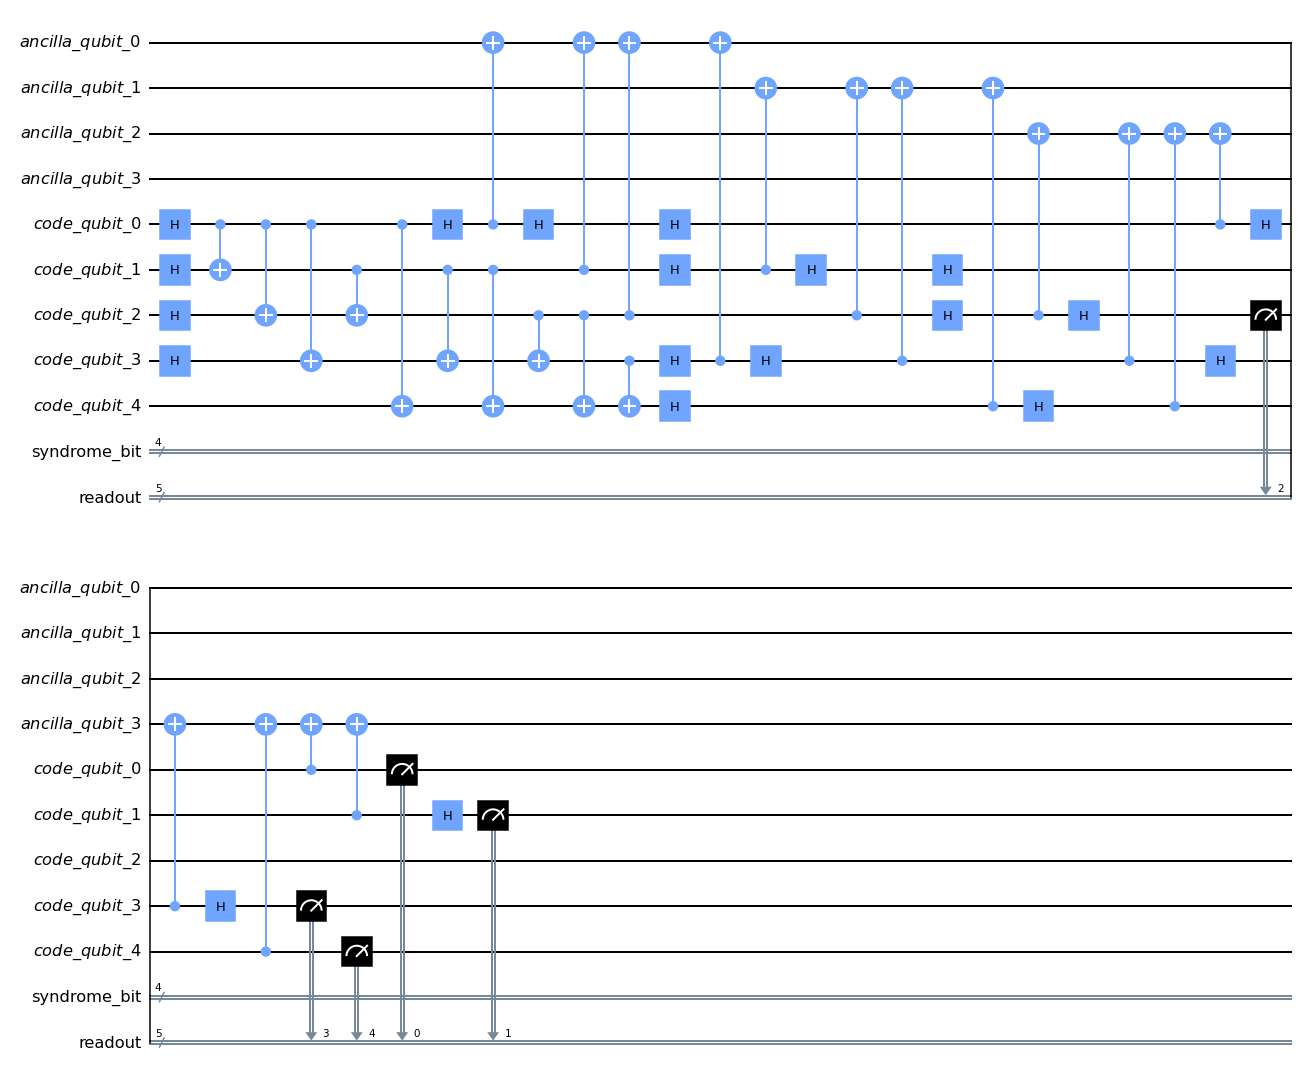

In [50]:
circuit = QuantumCircuit( cr, readout, an, qb )


# Encode the state
encode_input( circuit, qb ) # This one is incorrect
# (unfinished, need a way of encoding the logical zero
#  which is a superposition)

# Add errors manually
# (kinda pointless without proper encoding)

# Measure stabilizers
measure_stabilizer( circuit, qb, an, cr, 0 )
measure_stabilizer( circuit, qb, an, cr, 1 )
measure_stabilizer( circuit, qb, an, cr, 2 )
measure_stabilizer( circuit, qb, an, cr, 3 )

# Readout of the encoded state
circuit.measure( qb, readout )

counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)
circuit.draw(output='mpl') # If it does not work, simply remove mpl: circuit.draw()

# For now 'counts' looks messed up due to the fact that the current input state |00000> does
# not correspond to the logical 0. Measurements thus changes the state